## 1. Flow chart after Data monitoring
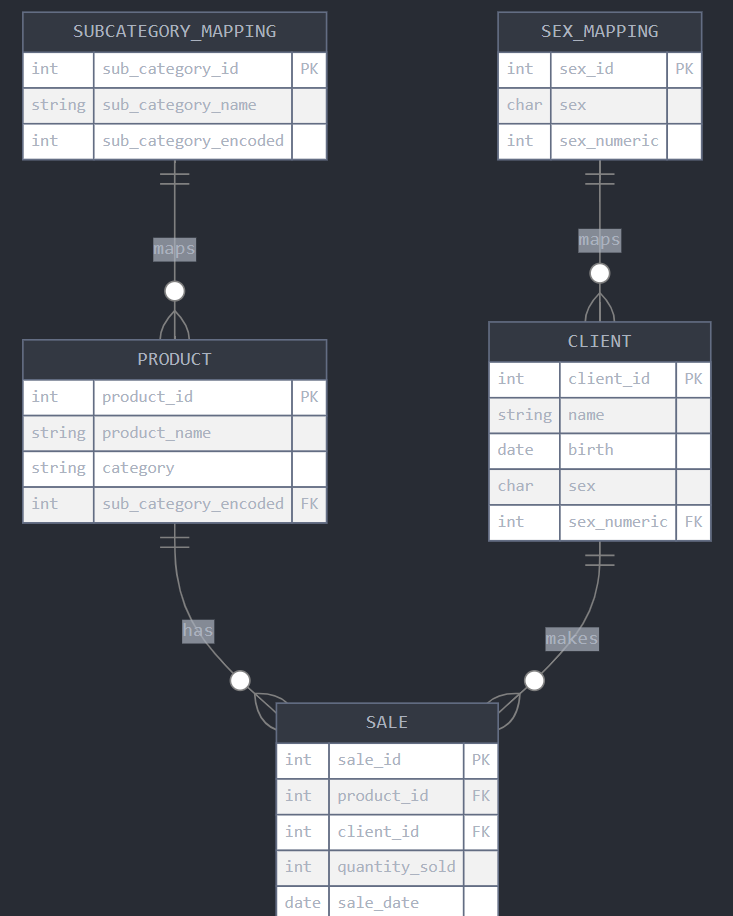

In [11]:
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Date, ForeignKey

In [12]:
# !pip install mysql-connector-python

In [13]:
from sqlalchemy import URL
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import create_engine, text

# Create a MetaData instance
metadata = MetaData()

url_object = URL.create(
    "mysql+pymysql",
    username="root",
    password="Ranjeeta1@",  # plain (unescaped) text
    host="localhost",
    database="sales_data",
)


# Create a metadata object
metadata = MetaData()

engine = create_engine(url_object)

In [14]:


# Assuming the engine is already created correctly
with engine.connect() as conn:
    # Create the database if it doesn't exist
    conn.execute(text("CREATE DATABASE IF NOT EXISTS sales_data;"))
    
    # Show all databases to confirm creation
    result = conn.execute(text("SHOW DATABASES;"))
    print(result.fetchall())

# No need for conn.commit(), as SQLAlchemy handles commits automatically for DDL queries.


[('information_schema',), ('mysql',), ('performance_schema',), ('sales_data',), ('sys',)]


In [15]:
# Drop all tables
metadata.drop_all(engine)

In [21]:

# # Create a metadata object
metadata = MetaData()

# Define tables
product = Table('Product', metadata,
    Column('product_id', String(100), primary_key=True),
    Column('category', String(100)),
    Column('sub_category_encoded', String(100))
)

client = Table('Client', metadata,
    Column('client_id', String(100), primary_key=True),
    Column('birth', Date),
    Column('sex', String(1)),
    # Column('sex_numeric', Integer)
)

sale = Table('Sale', metadata,
    # Column('sale_id', String(100), primary_key=True),
    Column('product_id', String(100), ForeignKey('Product.product_id')),
    Column('client_id', String(100), ForeignKey('Client.client_id')),
    Column('quantity_sold', Integer),
    Column('sale_date', Date)
)

# subcategory_mapping = Table('SubCategoryMapping', metadata,
#     Column('sub_category_id', Integer, primary_key=True),
#     Column('sub_category_name', String(100)),
#     Column('sub_category_encoded', Integer, unique=True)
# )

# sex_mapping = Table('SexMapping', metadata,
#     Column('sex', String(1), unique=True),
#     Column('sex_numeric', Integer, unique=True)
# )


# Create tables in the database
metadata.create_all(engine)

# Read CSV files
products_df = pd.read_csv('produits_sous-categorie.csv', sep = ";")
clients_df = pd.read_csv('clients.csv', sep = ";")
sales_df = pd.read_csv('ventes.csv', sep = ";")

print(products_df.columns)
sales_df.head()

Index(['product_id', 'category', 'sub_category', 'price', 'stock_quantity'], dtype='object')


,product_id,date,session_id,client_id,quantity_sold
0,0_1483,10/04/2021 18:37,s_18746,c_4450,5
1,2_226,03/02/2022 01:55,s_159142,c_277,6
2,1_374,23/09/2021 15:13,s_94290,c_4270,3
3,0_2186,17/10/2021 03:27,s_105936,c_4597,8
4,0_1351,17/07/2021 20:34,s_63642,c_1242,2


In [17]:
duplicate_products = products_df[products_df.duplicated(subset=['product_id'], keep=False)]
print(duplicate_products)


       product_id     category        sub_category  price  stock_quantity
0          0_1483    Vêtements            T-shirts   4,99              48
1           2_226      Montres  Montres connectées  65,75              63
2           1_374  Accessoires         Sacs à main  10,71              97
3          0_2186    Vêtements            T-shirts    4,2              57
4          0_1351    Vêtements            T-shirts   8,99              59
...           ...          ...                 ...    ...             ...
336483      1_671  Accessoires         Sacs à main  31,99              13
336484      0_759    Vêtements            T-shirts  22,99              65
336485     0_1256    Vêtements            T-shirts  11,03              13
336486      2_227      Montres  Montres connectées  50,99              94
336487     0_1417    Vêtements            T-shirts  17,99              38

[336441 rows x 5 columns]


In [18]:
with engine.connect() as connection:
    result = connection.execute(text("SELECT DATABASE();"))
    current_db = result.fetchone()[0]
    print(f"Connected to database: {current_db}")


Connected to database: sales_data


In [19]:
from sqlalchemy import inspect

inspector = inspect(engine)

# Get list of tables
tables = inspector.get_table_names()
print("Tables in database:", tables)

# Get details of a specific table
for table in tables:
    print(f"\nStructure of table '{table}':")
    columns = inspector.get_columns(table)
    for column in columns:
        print(f"{column['name']} - {column['type']}")


Tables in database: ['client', 'product', 'sale', 'sexmapping', 'subcategorymapping']

Structure of table 'client':
client_id - VARCHAR(100)
birth - DATE
sex - VARCHAR(1)

Structure of table 'product':
product_id - VARCHAR(100)
category - VARCHAR(100)
sub_category_encoded - VARCHAR(100)

Structure of table 'sale':
product_id - VARCHAR(100)
client_id - VARCHAR(100)
quantity_sold - INTEGER
sale_date - DATE

Structure of table 'sexmapping':
sex_id - INTEGER
sex - VARCHAR(1)
sex_numeric - INTEGER

Structure of table 'subcategorymapping':
sub_category_id - INTEGER
sub_category_name - VARCHAR(100)
sub_category_encoded - INTEGER


In [20]:
# Insert data into tables
with engine.connect() as connection:
    # Insert products
    for _, row in products_df.iterrows():
        ins = product.insert().prefix_with("IGNORE").values(
            product_id=row['product_id'],
            category=row['category'],
            sub_category_encoded=row['sub_category']
        )
        connection.execute(ins)

    # Insert clients
    for _, row in clients_df.iterrows():
        ins = client.insert().prefix_with("IGNORE").values(
            client_id=row['client_id'],
            birth=pd.to_datetime(row['birth']).date(),
            sex=row['sex'],
            # sex_numeric=row['sex_numeric']
        )
        connection.execute(ins)

    # Insert sales
    for _, row in sales_df.iterrows():
        ins = sale.insert().values(
            # sale_id=row['sale_id'],
            product_id=row['product_id'],
            client_id=row['client_id'],
            quantity_sold=row['quantity_sold'],
            sale_date=pd.to_datetime(row['date']).date()
        )
        connection.execute(ins)

    print("Data insertion completed successfully!")

    # Verify data insertion
    print("\nSample Products:")
    result = connection.execute(product.select().limit(5))
    for row in result:
        print(row)

    print("\nSample Clients:")
    result = connection.execute(client.select().limit(5))
    for row in result:
        print(row)

    print("\nSample Sales:")
    result = connection.execute(sale.select().limit(5))
    for row in result:
        print(row)

C:\Users\reegauta\AppData\Local\Temp\ipykernel_34812\1642609886.py:29: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sale_date=pd.to_datetime(row['date']).date()


Data insertion completed successfully!

Sample Products:
('0_0', 'Vêtements', 'T-shirts')
('0_1', 'Vêtements', 'T-shirts')
('0_10', 'Vêtements', 'T-shirts')
('0_100', 'Vêtements', 'T-shirts')
('0_1000', 'Vêtements', 'T-shirts')

Sample Clients:
('c_1', datetime.date(1970, 1, 1), 'm')
('c_10', datetime.date(1970, 1, 1), 'm')
('c_100', datetime.date(1970, 1, 1), 'm')
('c_1000', datetime.date(1970, 1, 1), 'f')
('c_1001', datetime.date(1970, 1, 1), 'm')

Sample Sales:
('0_1483', 'c_4450', 5, datetime.date(2021, 10, 4))
('2_226', 'c_277', 6, datetime.date(2022, 3, 2))
('1_374', 'c_4270', 3, datetime.date(2021, 9, 23))
('0_2186', 'c_4597', 8, datetime.date(2021, 10, 17))
('0_1351', 'c_1242', 2, datetime.date(2021, 7, 17))
